<div style="text-align: center; font-size: 24px; font-weight: bold; color: red;">
    Customer Lifetime Value Prediction _ FLO
</div>

FLO, an online shoe store, wants to segment its customers and develop marketing strategies based on these segments. Customer behaviors will be analyzed, and groups will be formed according to clusters identified in these behaviors.

The dataset consists of information derived from the past shopping behaviors of FLO customers who made their last purchases through OmniChannel (both online and offline) in the years 2020-2021.

FLO wants to establish a roadmap for its sales and marketing activities. In order for the company to make medium to long-term plans, it is necessary to estimate the potential value that existing customers will provide to the company in the future.

Data Dictionary

| **Variable** | **Description** |
|--------------|-----------------|
| **master_id** | Unique customer number |
| **order_channel** | The platform channel used for shopping (Android, iOS, Desktop, Mobile) |
| **last_order_channel** | The channel used for the last purchase |
| **first_order_date** | The date of the customer's first purchase |
| **last_order_date** | The date of the customer's most recent purchase |
| **last_order_date_online** | The date of the customer's most recent online purchase |
| **last_order_date_offline** | The date of the customer's most recent offline purchase |
| **order_num_total_ever_online** | Total number of purchases made by the customer on online platforms |
| **order_num_total_ever_offline** | Total number of purchases made by the customer on offline platforms |
| **customer_value_total_ever_offline** | The total amount spent by the customer on offline purchases |
| **customer_value_total_ever_online** | The total amount spent by the customer on online purchases |
| **interested_in_categories_12** | List of categories the customer has shopped in the last 12 months |


Variables: 12  
Observations: 19.945 

In [1]:
!pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.5 MB/s eta 0:00:00


Define the outlier_thresholds and replace_with_thresholds functions required to suppress outliers.

Note: When calculating cltv, frequency values ​​must be integer. Therefore, round the lower and upper limits with round().

In [2]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = (quartile3 + 1.5 * interquantile_range).round()
    low_limit = (quartile1 - 1.5 * interquantile_range).round()
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [3]:
df_ = pd.read_csv("/kaggle/input/flo-dataset/flo_data_20k.csv")

df = df_.copy()

Suppress any outliers in the variables "order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online".

In [4]:
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

In [5]:
# D. R. Y
# outlier_variables = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online"]
# for col in outlier_variables:
#     replace_with_thresholds(df, col)

Omnichannel refers to customers shopping from both online and offline platforms.
Create new variables for each customer's total number of purchases and spending.

In [6]:
df["total_customer_value"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

df["total_order_num"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

In [7]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_customer_value,total_order_num
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],939.3700,5.0000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.5500,21.0000
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",585.3200,5.0000
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",121.9700,2.0000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],209.9800,2.0000


Check the variable types. Convert the type of variables that include 'dates' to date.

In [8]:
date_columns = ["first_order_date", "last_order_date", "last_order_date_online", "last_order_date_offline"]
df[date_columns] = df[date_columns].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

Take 2 days after the date of the last purchase in the data set as the analysis date.

In [9]:
max_order_date = df["last_order_date"].max()

today_date = max_order_date + pd.Timedelta(days=2)
print(today_date)

2021-06-01 00:00:00


Create a new cltv dataframe containing the values ​​.customer_id, recency_cltv_weekly, T_weekly, frequency, and monetary_cltv_avg.

In [10]:
cltv = pd.DataFrame()
cltv["customer_id"] = df["master_id"]
cltv['recency_cltv_weekly'] = (df['last_order_date'] - df['first_order_date']).dt.days / 7
cltv["monetary_cltv_avg"] = (df["total_customer_value"] / df["total_order_num"])
cltv["T_weekly"] = (today_date - df['first_order_date']).dt.days / 7
cltv["frequency"] = df["total_order_num"]
cltv = cltv[cltv['recency_cltv_weekly'] > 0]

cltv.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_cltv_weekly,19920.0000,95.3831,74.5598,0.1429,50.5714,76.7143,109.5714,433.4286
monetary_cltv_avg,19920.0000,152.0125,73.4152,22.4900,103.6431,136.8354,182.4313,1401.8000
T_weekly,19920.0000,114.5881,74.7436,0.7143,74.0000,93.1429,119.4286,437.1429
frequency,19920.0000,4.9813,4.1224,2.0000,3.0000,4.0000,6.0000,57.0000


Set up the BG/NBD model.

In [11]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv['frequency'],
        cltv['recency_cltv_weekly'],
        cltv['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19920 subjects, a: 0.00, alpha: 76.26, b: 0.00, r: 3.66>

Estimate the expected purchases within the next 3 months and add it to the cltv dataframe as 'exp_sales_3_month'.

In [12]:
cltv["exp_sales_3_month"] = bgf.predict(4 * 3,
            cltv['frequency'],
            cltv['recency_cltv_weekly'],
            cltv['T_weekly'])

cltv = cltv.sort_values(by="exp_sales_3_month", ascending=False)
cltv.head()

,customer_id,recency_cltv_weekly,monetary_cltv_avg,T_weekly,frequency,exp_sales_3_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,166.2246,67.2857,52.0000,4.6534
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,165.2976,40.0000,29.0000,3.3715
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.8571,97.4396,33.2857,25.0000,3.1400
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,228.5300,58.7143,31.0000,3.0819
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.0000,141.3548,46.4286,27.0000,2.9993


Estimate the expected purchases from customers in 6 months and add it to the cltv dataframe as exp_sales_6_month.

In [13]:
cltv["exp_sales_6_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6,
                                                        cltv['frequency'],
                                                        cltv['recency_cltv_weekly'],
                                                        cltv['T_weekly'])

cltv = cltv.sort_values(by="exp_sales_6_month", ascending=False)
cltv.head()

,customer_id,recency_cltv_weekly,monetary_cltv_avg,T_weekly,frequency,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,166.2246,67.2857,52.0000,4.6534,9.3068
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,165.2976,40.0000,29.0000,3.3715,6.7431
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.8571,97.4396,33.2857,25.0000,3.1400,6.2800
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,228.5300,58.7143,31.0000,3.0819,6.1638
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.0000,141.3548,46.4286,27.0000,2.9993,5.9985


Graph your prediction results

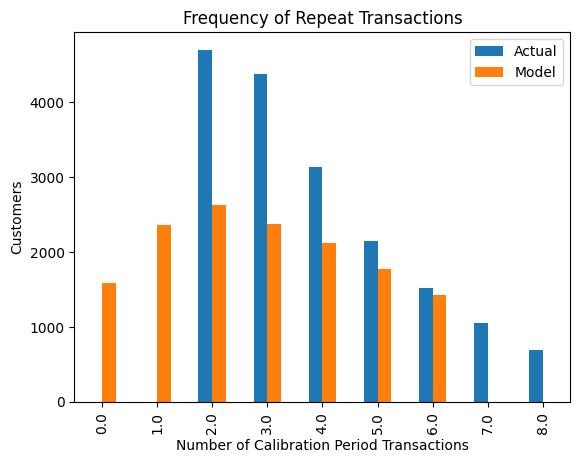

In [14]:
plot_period_transactions(bgf)
plt.show()

Review the 10 people who will make the most purchases in the 3rd and 6th months.

In [15]:
cltv.groupby("customer_id").agg({"exp_sales_3_month": "sum",
                               "exp_sales_6_month": "sum"}).sort_values(by="exp_sales_6_month", ascending=False).head(10)

,exp_sales_3_month,exp_sales_6_month
customer_id,,
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,4.6534,9.3068
4a7e875e-e6ce-11ea-8f44-000d3a38a36f,3.3715,6.7431
1902bf80-0035-11eb-8341-000d3a38a36f,3.1400,6.2800
55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,3.0819,6.1638
f00ad516-c4f4-11ea-98f7-000d3a38a36f,2.9993,5.9985
7af5cd16-b100-11e9-9757-000d3a38a36f,2.9767,5.9535
d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,2.8289,5.6577
27310582-6362-11ea-a6dc-000d3a38a36f,2.7918,5.5836
53fe00d4-7b7a-11eb-960b-000d3a38a36f,2.7781,5.5563


Fit the Gamma-Gamma model. Estimate the average value that customers will leave and add it to the cltv dataframe as exp_average_value.

In [16]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv['frequency'], cltv['monetary_cltv_avg'])

cltv["exp_average_value"] = ggf.conditional_expected_average_profit(cltv['frequency'],
                                                                             cltv['monetary_cltv_avg'])
cltv.sort_values("exp_average_value", ascending=False).head(10)

,customer_id,recency_cltv_weekly,monetary_cltv_avg,T_weekly,frequency,exp_sales_3_month,exp_sales_6_month,exp_average_value
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,1401.8000,7.8571,4.0000,1.0934,2.1869,1449.0490
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,1106.4671,101.0000,7.0000,0.7220,1.4439,1127.6065
15516,9083981a-f59e-11e9-841e-000d3a38a36f,63.5714,1090.3600,83.8571,4.0000,0.5744,1.1489,1127.3455
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,862.6900,9.4286,2.0000,0.7933,1.5866,923.6649
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57.0000,859.5800,94.8571,2.0000,0.3973,0.7945,920.3429
1853,f02473b0-43c3-11eb-806e-000d3a38a36f,17.2857,835.8750,23.1429,2.0000,0.6839,1.3677,895.0223
7936,ae4ce104-dbd4-11ea-8757-000d3a38a36f,3.7143,844.3467,42.0000,3.0000,0.6763,1.3526,883.2786
9738,3a27b334-dff4-11ea-acaa-000d3a38a36f,40.0000,837.0567,41.1429,3.0000,0.6812,1.3624,875.6647
12828,0c24fc44-2ac8-11ea-9d27-000d3a38a36f,68.0000,779.2650,84.2857,2.0000,0.4234,0.8468,834.5540
2291,26ac1432-1dd3-11ea-8bf2-000d3a38a36f,55.7143,780.5567,97.7143,3.0000,0.4597,0.9194,816.6546


Calculate the 6-month CLTV and add it to the dataframe as "cltv".

In [17]:
cltv["cltv"] = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency_cltv_weekly'],
                                   cltv['T_weekly'],
                                   cltv['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)


Review the 20 people with the highest CLTV values.

In [18]:
cltv.sort_values("cltv", ascending=False, ignore_index=True).head(20)

,customer_id,recency_cltv_weekly,monetary_cltv_avg,T_weekly,frequency,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
0,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,1401.8000,7.8571,4.0000,1.0934,2.1869,1449.0490,3324.8728
1,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,758.0855,13.1429,11.0000,1.9684,3.9367,767.3584,3169.5610
2,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,1106.4671,101.0000,7.0000,0.7220,1.4439,1127.6065,1708.3497
3,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,501.8737,74.5714,16.0000,1.5645,3.1290,506.1657,1661.7573
4,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,166.2246,67.2857,52.0000,4.6534,9.3068,166.7122,1627.9272
5,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,601.2262,34.4286,8.0000,1.2646,2.5292,611.4902,1622.7087
6,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,862.6900,9.4286,2.0000,0.7933,1.5866,923.6649,1537.6292
7,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,259.8653,13.0000,17.0000,2.7781,5.5563,262.0724,1527.8188
8,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,228.5300,58.7143,31.0000,3.0819,6.1638,229.6067,1484.9075
9,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,743.5867,15.5714,3.0000,0.8709,1.7418,778.0421,1421.9184


Divide all your customers into 4 groups (segments) based '6-month cltv' and add the group names to the data set as 'cltv_segment'.

In [19]:
cltv["cltv_segment"] = pd.qcut(cltv["cltv"], 4, labels=["D", "C", "B", "A"])

Check the recency, frequency and monetary averages of the segments.

In [20]:
cltv.groupby("cltv_segment").agg({"recency_cltv_weekly": "mean",
                                                  "frequency": "mean",
                                                  "monetary_cltv_avg": "mean"})

,recency_cltv_weekly,frequency,monetary_cltv_avg
cltv_segment,,,
D,139.0005,3.7667,93.1371
C,92.7114,4.4024,125.7567
B,82.1427,5.0976,160.6087
A,67.6776,6.6586,228.5473


Bonus - Write a function for all these steps

In [21]:
def create_cltv_p(dataframe):
    replace_with_thresholds(df, "order_num_total_ever_online")
    replace_with_thresholds(df, "order_num_total_ever_offline")
    replace_with_thresholds(df, "customer_value_total_ever_offline")
    replace_with_thresholds(df, "customer_value_total_ever_online")

    dataframe["total_customer_value"] = dataframe["customer_value_total_ever_offline"] + dataframe["customer_value_total_ever_online"]
    dataframe["total_order_num"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]

    date_columns = ["first_order_date", "last_order_date", "last_order_date_online", "last_order_date_offline"]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    max_order_date = dataframe["last_order_date"].max()
    today_date = max_order_date + pd.Timedelta(days=2)

    cltv = pd.DataFrame()
    cltv["customer_id"] = dataframe["master_id"]
    cltv['recency_cltv_weekly'] = (dataframe['last_order_date'] - dataframe['first_order_date']).dt.days / 7
    cltv["monetary_cltv_avg"] = (dataframe["total_customer_value"] / df["total_order_num"])
    cltv["T_weekly"] = (today_date - dataframe['first_order_date']).dt.days / 7
    cltv["frequency"] = dataframe["total_order_num"]
    cltv = cltv[cltv['recency_cltv_weekly'] > 0]



    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv['frequency'],
            cltv['recency_cltv_weekly'],
            cltv['T_weekly'])


    cltv["exp_sales_3_month"] = bgf.predict(4 * 3,
                                            cltv['frequency'],
                                            cltv['recency_cltv_weekly'],
                                            cltv['T_weekly'])

    cltv = cltv.sort_values(by="exp_sales_3_month", ascending=False)

    cltv["exp_sales_6_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6,
                                                                                        cltv['frequency'],
                                                                                        cltv['recency_cltv_weekly'],
                                                                                        cltv['T_weekly'])

    cltv = cltv.sort_values(by="exp_sales_6_month", ascending=False)

    cltv.groupby("customer_id").agg({"exp_sales_3_month": "sum",
                                     "exp_sales_6_month": "sum"}).sort_values(by="exp_sales_6_month",
                                                                              ascending=False).head(10)


    ggf = GammaGammaFitter(penalizer_coef=0.01)

    ggf.fit(cltv['frequency'], cltv['monetary_cltv_avg'])

    cltv["exp_average_value"] = ggf.conditional_expected_average_profit(cltv['frequency'],
                                                                        cltv['monetary_cltv_avg'])
    cltv.sort_values("exp_average_value", ascending=False).head(10)


    cltv["cltv"] = ggf.customer_lifetime_value(bgf,
                                               cltv['frequency'],
                                               cltv['recency_cltv_weekly'],
                                               cltv['T_weekly'],
                                               cltv['monetary_cltv_avg'],
                                               time=6,
                                               freq="W",
                                               discount_rate=0.01)

    cltv.sort_values("cltv", ascending=False, ignore_index=True).head(20)

    cltv["cltv_segment"] = pd.qcut(cltv["cltv"], 4, labels=["D", "C", "B", "A"])

    segment_overview = cltv.groupby("cltv_segment").agg({"recency_cltv_weekly": "mean",
                                      "frequency": "mean",
                                      "monetary_cltv_avg": "mean"})
    print(segment_overview)

    return cltv

In [22]:
df = df_.copy()

cltv_final = create_cltv_p(df)

cltv_final.sort_values("cltv", ascending=False, ignore_index=True).head(20)

              recency_cltv_weekly  frequency  monetary_cltv_avg
cltv_segment                                                   
D                        139.0005     3.7667            93.1371
C                         92.7114     4.4024           125.7567
B                         82.1427     5.0976           160.6087
A                         67.6776     6.6586           228.5473


,customer_id,recency_cltv_weekly,monetary_cltv_avg,T_weekly,frequency,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,1401.8000,7.8571,4.0000,1.0934,2.1869,1449.0490,3324.8728,A
1,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,758.0855,13.1429,11.0000,1.9684,3.9367,767.3584,3169.5610,A
2,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,1106.4671,101.0000,7.0000,0.7220,1.4439,1127.6065,1708.3497,A
3,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,501.8737,74.5714,16.0000,1.5645,3.1290,506.1657,1661.7573,A
4,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,166.2246,67.2857,52.0000,4.6534,9.3068,166.7122,1627.9272,A
5,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,601.2262,34.4286,8.0000,1.2646,2.5292,611.4902,1622.7087,A
6,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,862.6900,9.4286,2.0000,0.7933,1.5866,923.6649,1537.6292,A
7,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,259.8653,13.0000,17.0000,2.7781,5.5563,262.0724,1527.8188,A
8,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,228.5300,58.7143,31.0000,3.0819,6.1638,229.6067,1484.9075,A
9,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,743.5867,15.5714,3.0000,0.8709,1.7418,778.0421,1421.9184,A
